In [2]:
# Install necessary libraries (if you haven't already)
# pip install pandas scikit-learn numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Using RandomForest for better performance
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- Data Simulation Code ---
np.random.seed(42)
n_samples = 1500 # A good number for a simple capstone project

# 1. 'Healthy' (Label 0): Optimal conditions
healthy_data = pd.DataFrame({
    'Temperature': np.random.uniform(20, 26, n_samples), # Celsius
    'Humidity': np.random.uniform(40, 60, n_samples),     # Percentage
    'Light': np.random.uniform(500, 800, n_samples),      # Lux
    'SoilMoisture': np.random.uniform(40, 65, n_samples), # Percentage
    'State': 0
})

# 2. 'Needs Water' (Label 1): Low soil moisture, slightly higher temp/lower humidity
needs_water_data = pd.DataFrame({
    'Temperature': np.random.uniform(25, 30, n_samples),
    'Humidity': np.random.uniform(30, 45, n_samples),
    'Light': np.random.uniform(700, 950, n_samples),
    'SoilMoisture': np.random.uniform(10, 35, n_samples),
    'State': 1
})

# 3. 'Overwatered' (Label 2): High soil moisture, slightly lower temp/high humidity
overwatered_data = pd.DataFrame({
    'Temperature': np.random.uniform(18, 22, n_samples),
    'Humidity': np.random.uniform(60, 80, n_samples),
    'Light': np.random.uniform(300, 550, n_samples),
    'SoilMoisture': np.random.uniform(70, 95, n_samples),
    'State': 2
})

# Combine all data
df = pd.concat([healthy_data, needs_water_data, overwatered_data], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

print("Generated Dataset Head:")
print(df.head())
print(f"\nTotal Samples: {len(df)}")

Generated Dataset Head:
   Temperature   Humidity       Light  SoilMoisture  State
0    22.074176  40.912975  747.965322     62.278502      0
1    25.324496  30.829986  830.020671     33.738436      1
2    27.862039  41.707827  739.713173     27.029314      1
3    24.089016  58.215403  789.008096     44.516439      0
4    19.855122  62.904657  533.273518     78.115431      2

Total Samples: 4500


In [4]:
# Define features (X) and target (y)
X = df.drop('State', axis=1)
y = df['State']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData splitting and scaling complete.")


Data splitting and scaling complete.


In [5]:
# Initialize the model (using RandomForest for better accuracy)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

print("\nModel training complete.")


Model training complete.



--- Model Evaluation ---
Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       294
 Needs Water       1.00      1.00      1.00       306
 Overwatered       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



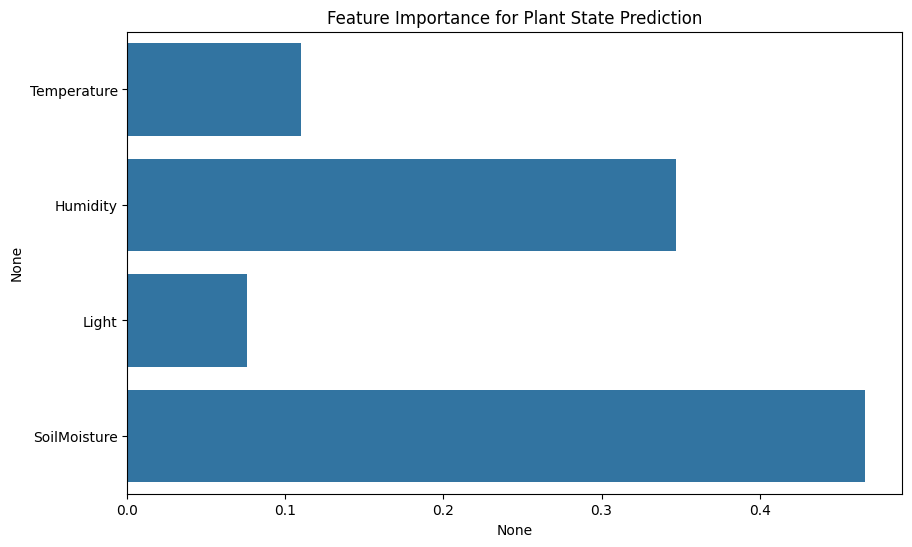

In [6]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Print evaluation metrics
print("\n--- Model Evaluation ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Needs Water', 'Overwatered']))

# Visualizing Feature Importance (a great capstone addition!)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance for Plant State Prediction')
plt.show()

In [7]:
# Mapping of numeric labels to state names
STATE_MAP = {0: 'Healthy', 1: 'Needs Water', 2: 'Overwatered'}

def get_plant_alert(temp, hum, light, soil_moisture, model, scaler):
    # 1. Create a DataFrame for the new input
    new_data = pd.DataFrame({
        'Temperature': [temp],
        'Humidity': [hum],
        'Light': [light],
        'SoilMoisture': [soil_moisture]
    })

    # 2. Scale the input data
    new_data_scaled = scaler.transform(new_data)

    # 3. Predict the state
    prediction_label = model.predict(new_data_scaled)[0]
    prediction_state = STATE_MAP[prediction_label]

    # 4. Get the confidence (probability) of the predicted state
    probabilities = model.predict_proba(new_data_scaled)[0]
    confidence_score = probabilities[prediction_label]

    # 5. Generate the alert
    if prediction_state == 'Needs Water':
        alert = "🚨 ACTION REQUIRED: The plant is likely dry!"
    elif prediction_state == 'Overwatered':
        alert = "⚠️ WARNING: The plant is likely overwatered. Stop watering for a few days!"
    else:
        alert = "✅ STATUS: Your plant is happy and healthy."

    return {
        'State': prediction_state,
        'Confidence': f"{confidence_score * 100:.2f}%",
        'Alert': alert
    }

In [8]:
print("\n--- Smart Plant Alert System Demo ---")

# Scenario A: Healthy conditions (Soil Moisture ~50)
reading_A = get_plant_alert(temp=23, hum=55, light=700, soil_moisture=50, model=model, scaler=scaler)
print(f"\nReading A (Simulated Healthy): {reading_A['State']} | Confidence: {reading_A['Confidence']} | Alert: {reading_A['Alert']}")

# Scenario B: Needs Water (Soil Moisture ~20)
reading_B = get_plant_alert(temp=28, hum=40, light=850, soil_moisture=20, model=model, scaler=scaler)
print(f"Reading B (Simulated Dry): {reading_B['State']} | Confidence: {reading_B['Confidence']} | Alert: {reading_B['Alert']}")

# Scenario C: Overwatered (Soil Moisture ~80)
reading_C = get_plant_alert(temp=20, hum=75, light=450, soil_moisture=80, model=model, scaler=scaler)
print(f"Reading C (Simulated Wet): {reading_C['State']} | Confidence: {reading_C['Confidence']} | Alert: {reading_C['Alert']}")


--- Smart Plant Alert System Demo ---

Reading A (Simulated Healthy): Healthy | Confidence: 100.00% | Alert: ✅ STATUS: Your plant is happy and healthy.
Reading B (Simulated Dry): Needs Water | Confidence: 100.00% | Alert: 🚨 ACTION REQUIRED: The plant is likely dry!
Reading C (Simulated Wet): Overwatered | Confidence: 100.00% | Alert: ⚠️ WARNING: The plant is likely overwatered. Stop watering for a few days!


In [9]:
import joblib

# After training the model and scaler
joblib.dump(model, 'plant_classifier_model.pkl')
joblib.dump(scaler, 'plant_scaler.pkl')

['plant_scaler.pkl']